## Reference Paper:

https://arxiv.org/pdf/1312.6114

#import required libraries 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
np.random.seed(42)

In [2]:
# The following code generates simple polygons in the center of an image of size "img_size" at random angles
def rotate_points(coordinates, theta):    
    theta_rad = np.radians(theta)
    
    # Rotation matrix for 2D rotation around the z-axis
    rotation_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                                [np.sin(theta_rad), np.cos(theta_rad)]])
    
    # Apply rotation: [x', y'] = R(theta) * [x, y]
    rotated_coords = rotation_matrix.dot(coordinates.T)
    
    return rotated_coords.T

def polygon_coordinates(r, c, n, rotation_angle):
    cx, cy = c
    # Angle increment between vertices
    theta = 2 * np.pi / n
    
    # List to store the coordinates
    coordinates = []
    
    for i in range(n):
        # Calculate the coordinates of each vertex
        x = r * np.cos(theta * i)
        y = r * np.sin(theta * i)
        coordinates.append([x, y])
    
    coordinates.append(coordinates[0])    
    coordinates = np.array(coordinates)

    coordinates = rotate_points(coordinates, rotation_angle)
    
    coordinates[:,0] += cx
    coordinates[:,1] += cx
    
    return coordinates.astype('int32')

def circumradius(a, N):
    """Calculate the radius of the circumcircle for a regular polygon with N sides and side length a."""
    return a / (2*np.tan(np.deg2rad(180/N)))

def create_polygons(img_size,n_min,n_max):  
    if img_size<32:
        img_size = 32
    if img_size>1024:
        img_size = 1024
        
    if n_min<3:
        n_min = 3
    if n_min>24:
        n_min = 24   
        
    if n_max<n_min:
        n_max = n_min+1
        
    image = np.zeros((img_size, img_size, 1), dtype=np.uint8)     
        
    n = np.random.randint(n_min,n_max) # number of edges between 3 and 6       
    r = circumradius(a = img_size, N = 4)
    
    x_y_c = [r,r]
    r = r*0.7    # shrink factor
    coords = polygon_coordinates(r, x_y_c, n, np.random.randint(0,360))          
    coords = coords.reshape((-1, 1, 2))       
    
    cv2.fillPoly(image, [coords], (255,255,255))        
    
    image = (image/255.0).astype('float32')
    return [image,n]

### Here are a few examples demonstrating how to use the code above to generate sample images with a polygon randomly oriented at the center of the image.

Number of Edges = 5
Number of Edges = 5
Number of Edges = 6
Number of Edges = 3
Number of Edges = 4


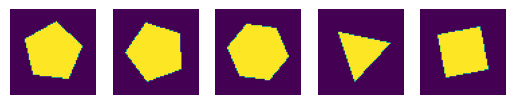

In [3]:
for i in range(5):
    image,n = create_polygons(img_size = 64, n_min = 3, n_max = 7)
    plt.subplot(1,5,i+1)
    plt.imshow(image)
    plt.axis('off')
    print('Number of Edges = '+str(n))

## Now we create the training/testing images

Number of Edges = 6


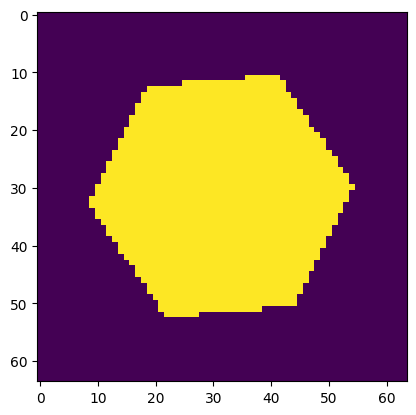

In [5]:
training = [create_polygons(img_size = 64, n_min = 3, n_max = 7) for i in range(10000)]
training_images = np.array([i[0] for i in training])
training_images_n = np.array([i[1] for i in training])

testing = [create_polygons(img_size = 64, n_min = 3, n_max = 7) for i in range(1000)]
testing_images = np.array([i[0] for i in testing])
testing_images_n = np.array([i[1] for i in testing])

plt.imshow(training_images[0])
print('Number of Edges = '+str(testing_images_n[0]))

## Now we create a simple VAE model

In [6]:
def sampling(args):
    z_mean, z_sigma = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_sigma) * epsilon

def build_encoder(latent_dim):
    input_image = layers.Input(shape=(64,64,1))
    d = layers.Conv2D(16, 3, strides=2, padding='same', activation = 'relu')(input_image)	    
    d = layers.Conv2D(32, 3, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(64, 3, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(128, 3, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(256, 3, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(512, 3, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation='relu')(d)  
    d = layers.Dense(128, activation='relu')(d)
    
    z_mu = layers.Dense(latent_dim, name='latent_mu')(d)   #Mean values of encoded input
    z_sigma = layers.Dense(latent_dim, name='latent_sigma')(d)  #Std dev. (variance) of encoded input    
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_sigma])

    model = models.Model(input_image, [z_mu,z_sigma,z])
    model.summary()
    return model

def build_decoder(latent_dim):
    input_layer = layers.Input(shape=(latent_dim,))    
    d = layers.Dense(32, activation='relu')(input_layer)
    d = layers.Dense(64, activation='relu')(d)
    d = layers.Dense(128, activation='relu')(d)
    d = layers.Dense(256, activation='relu')(d)
    d = layers.Dense(1*1*512, activation='relu')(d)
    d = layers.Reshape((1, 1, 512))(d)    

    # Decoder (Upsampling)   
    d = layers.Conv2DTranspose(512, 3, activation='relu', strides=2, padding='same')(d)  
    d = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(d)  
    d = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(d)  
    d = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(d)  
    d = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(d)  
    output_layer = layers.Conv2DTranspose(1, 3, activation='sigmoid', strides=2, padding='same')(d)  
    
    # Output layer
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.summary()        
    return model

def build_vae(encoder, decoder):
    inputs = layers.Input(shape = (64,64,1))     
    # Encoder output
    z_mean, z_sigma, z = encoder(inputs)
    
    # Decoder output
    reconstructed_img = decoder(z)
    
    # VAE loss function
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstructed_img), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), axis=1))    
    vae_loss = reconstruction_loss + kl_loss 
    
    # VAE model
    vae = models.Model(inputs, reconstructed_img, name="vae")
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')    
    vae.summary()
    return vae

latent_dim = 2 # this is the dimension of the latent space
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = build_vae(encoder,decoder)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
#### lets start training the model for 100 epochs
history = vae.fit(training_images, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100
63/63 [==============================] - 10s 35ms/step - loss: 1271.2317 - val_loss: 618.4141
Epoch 2/100
63/63 [==============================] - 2s 26ms/step - loss: 589.0920 - val_loss: 566.6313
Epoch 3/100
63/63 [==============================] - 2s 26ms/step - loss: 502.7367 - val_loss: 427.7958
Epoch 4/100
63/63 [==============================] - 2s 26ms/step - loss: 387.7089 - val_loss: 364.9492
Epoch 5/100
63/63 [==============================] - 2s 26ms/step - loss: 356.6595 - val_loss: 353.7889
Epoch 6/100
63/63 [==============================] - 2s 26ms/step - loss: 341.3048 - val_loss: 355.1837
Epoch 7/100
63/63 [==============================] - 2s 26ms/step - loss: 322.8770 - val_loss: 309.6938
Epoch 8/100
63/63 [==============================] - 2s 26ms/step - loss: 307.0753 - val_loss: 303.6829
Epoch 9/100
63/63 [==============================] - 2s 26ms/step - loss: 295.2921 - val_loss: 284.4449
Epoch 10/100
63/63 [==============================] - 2s 26ms/

Text(0.5, 0, 'Epochs')

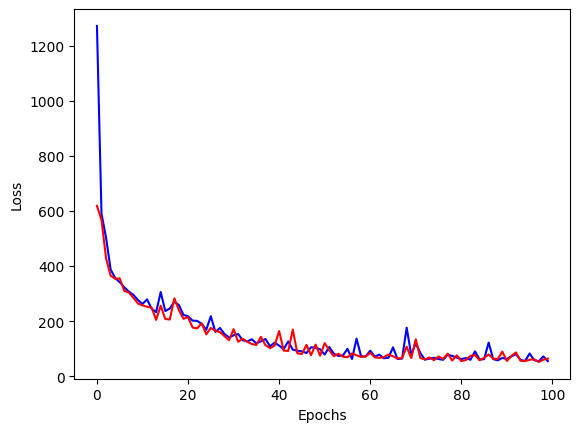

In [9]:
#################### Model Training/Tunning Loss ###############
#################### Model Training/Tunning Loss ###############
plt.figure()
plt.plot(history.history['loss'], c = 'b')
plt.plot(history.history['val_loss'], c = 'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')

### Lets obtain model predicitons on the testing images:

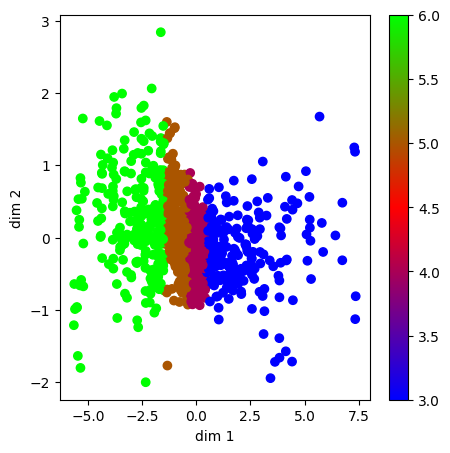

In [13]:
mu, sigma, z = encoder.predict(testing_images)

# we can also plot the distribution of the latent dimension
plt.figure(figsize=(5, 5))
plt.scatter(z[:, 0], z[:, 1], c=testing_images_n, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

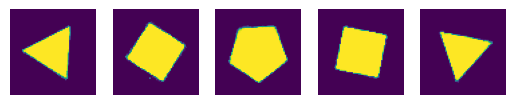

In [14]:
#sample prediction
for i in range(5):
    plt.subplot(1,5,i+1)
    sample_vector = np.array(np.random.randn(1,latent_dim))
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(64, 64, 1)
    plt.imshow(decoded_example_reshaped)
    plt.axis('off')

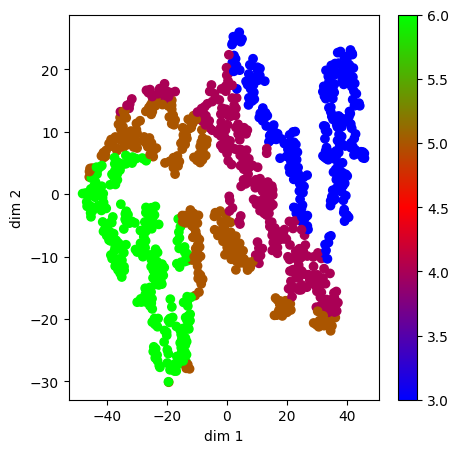

In [16]:
# We can use t-SNE to better visualize the separability of the latent dimensions across the 4 classes:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_scaled)
plt.figure(figsize=(5, 5))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=testing_images_n, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

(-0.5, 1279.5, 1279.5, -0.5)

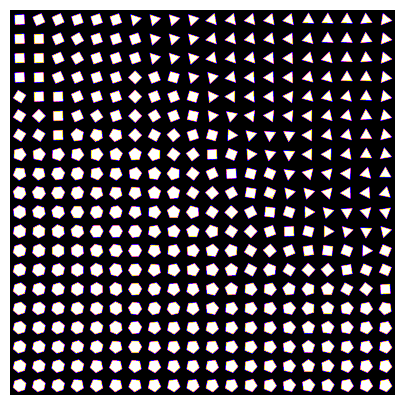

In [18]:
## we can also generate sample images using values in the latent space above:
n = 20  # generate 15x15 digits
figure = np.zeros((64 * n, 64 * n, 1))
#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-40, 40, n)
grid_y = np.linspace(-40, 40, n)[::-1]
# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        distances = np.linalg.norm(z_tsne - z_sample, axis=1)        
        closest_index = np.argmin(distances) 
        x_decoded = decoder.predict(np.expand_dims(z[closest_index,:],axis = 0))
        digit = x_decoded[0].reshape(64, 64, 1)
        figure[i * 64: (i + 1) * 64,
               j * 64: (j + 1) * 64] = digit
plt.figure(figsize=(5, 5))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.axis('off')